<a href="https://colab.research.google.com/github/liyachittilappilly/abs/blob/main/abs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install tensorflow scikit-learn matplotlib opencv-python

# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

Mounted at /content/drive


In [ ]:
# Define image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Define directory containing the image data
data_dir = '/content/drive/MyDrive/data' # Update this path to your data directory

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Using 20% of data for validation

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 21 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [ ]:
# Define dataset path
DATASET_PATH = '/content/drive/MyDrive/data'  # Update to your path

# Check folder structure
print("Contents of dataset directory:")
print(os.listdir(DATASET_PATH))

# Check subdirectories
print("\nContents of '0' (no abs) folder:", len(os.listdir(os.path.join(DATASET_PATH, '0'))), "images")
print("Contents of '3' (abs) folder:", len(os.listdir(os.path.join(DATASET_PATH, '3'))), "images")

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    classes=['0', '3'],  # Explicitly define class order
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    classes=['0', '3'],  # Explicitly define class order
    subset='validation')

# Verify class indices
print("\nClass indices:", train_generator.class_indices)  # Should show {'0': 0, '3': 1}

Contents of dataset directory:
['3', '0']

Contents of '0' (no abs) folder: 8 images
Contents of '3' (abs) folder: 17 images
Found 21 images belonging to 2 classes.
Found 4 images belonging to 2 classes.

Class indices: {'0': 0, '3': 1}


In [ ]:
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Feature extraction function
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 4 * 4 * 512))  # VGG16 block5_pool output
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = feature_extractor.predict(inputs_batch)
        features[i * len(inputs_batch): (i + 1) * len(inputs_batch)] = features_batch.reshape(len(inputs_batch), -1)
        labels[i * len(inputs_batch): (i + 1) * len(inputs_batch)] = labels_batch
        i += 1
        if i * len(inputs_batch) >= sample_count:
            break
    return features, labels

# Extract features
train_features, train_labels = extract_features(train_generator, train_generator.samples)
validation_features, validation_labels = extract_features(validation_generator, validation_generator.samples)

print(f"\nTrain features shape: {train_features.shape}")
print(f"Validation features shape: {validation_features.shape}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step

Train features shape: (21, 8192)
Validation features shape: (4, 8192)


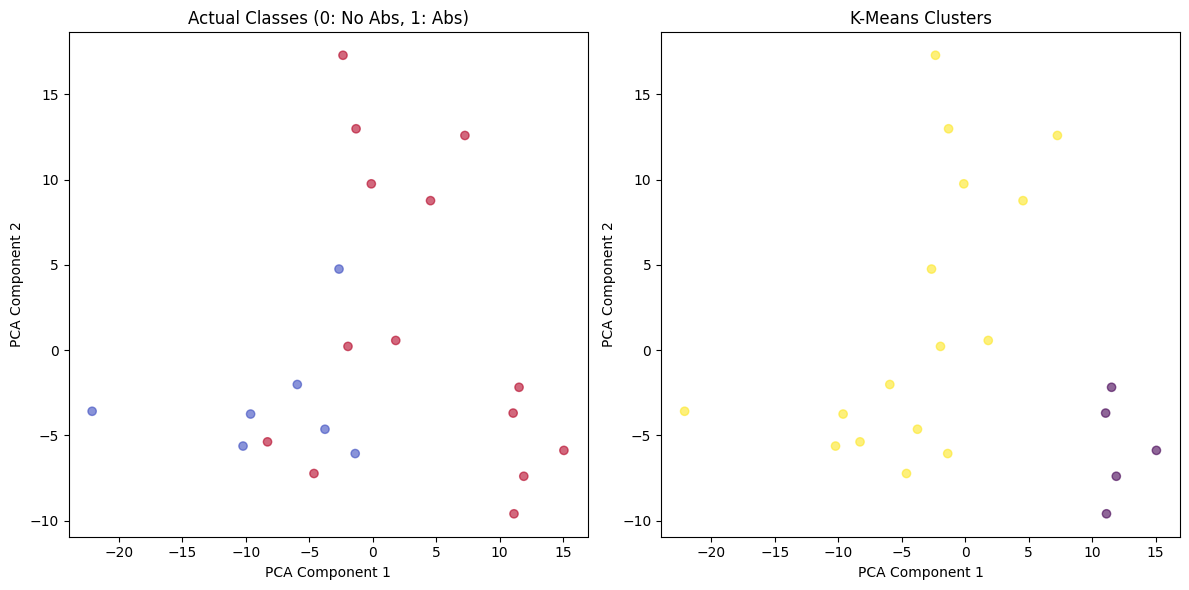


Cluster Analysis:
Cluster 0 - No Abs images: 0
Cluster 0 - Abs images: 5
Cluster 1 - No Abs images: 7
Cluster 1 - Abs images: 9


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Apply PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
train_features_pca = pca.fit_transform(train_features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(train_features)

# Visualize clusters
plt.figure(figsize=(12, 6))

# Plot actual classes
plt.subplot(1, 2, 1)
plt.scatter(train_features_pca[:, 0], train_features_pca[:, 1], c=train_labels, cmap='coolwarm', alpha=0.6)
plt.title("Actual Classes (0: No Abs, 1: Abs)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot predicted clusters
plt.subplot(1, 2, 2)
plt.scatter(train_features_pca[:, 0], train_features_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("K-Means Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

# Analyze cluster composition
cluster_0_indices = np.where(clusters == 0)[0]
cluster_1_indices = np.where(clusters == 1)[0]

print("\nCluster Analysis:")
print(f"Cluster 0 - No Abs images: {np.sum(train_labels[cluster_0_indices] == 0)}")
print(f"Cluster 0 - Abs images: {np.sum(train_labels[cluster_0_indices] == 1)}")
print(f"Cluster 1 - No Abs images: {np.sum(train_labels[cluster_1_indices] == 0)}")
print(f"Cluster 1 - Abs images: {np.sum(train_labels[cluster_1_indices] == 1)}")


Validation Accuracy: 100.00%


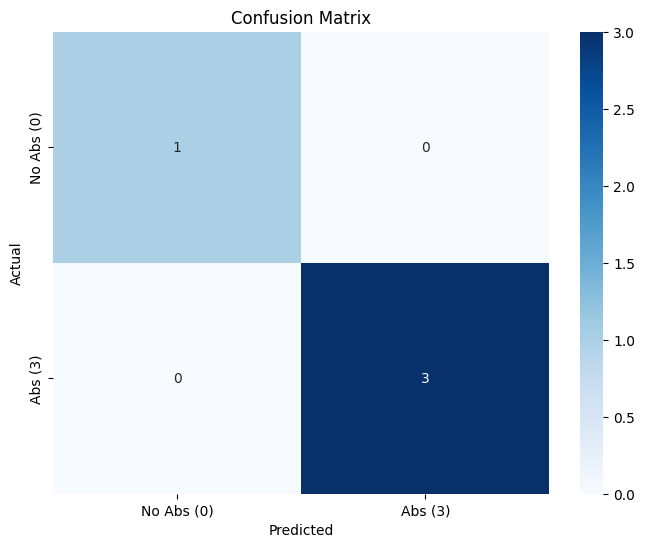


Classification Report:
              precision    recall  f1-score   support

  No Abs (0)       1.00      1.00      1.00         1
     Abs (3)       1.00      1.00      1.00         3

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Train Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(train_features, train_labels)

# Evaluate on validation set
val_predictions = classifier.predict(validation_features)
val_accuracy = accuracy_score(validation_labels, val_predictions)
print(f"\nValidation Accuracy: {val_accuracy:.2%}")

# Confusion Matrix
cm = confusion_matrix(validation_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Abs (0)', 'Abs (3)'],
            yticklabels=['No Abs (0)', 'Abs (3)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(validation_labels, val_predictions,
                          target_names=['No Abs (0)', 'Abs (3)']))